# Updating Time Series with Linear Framework

In [1]:
import numpy as np # for data manipulation
import pandas as pd # for numeric operations
import matplotlib.pyplot as plt # for plotting
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX  # for SARIMAX model
from statsmodels.tsa.stattools import adfuller          # for stationarity test (ADF)
from statsmodels.tools.eval_measures import rmse        # for forecast error evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error

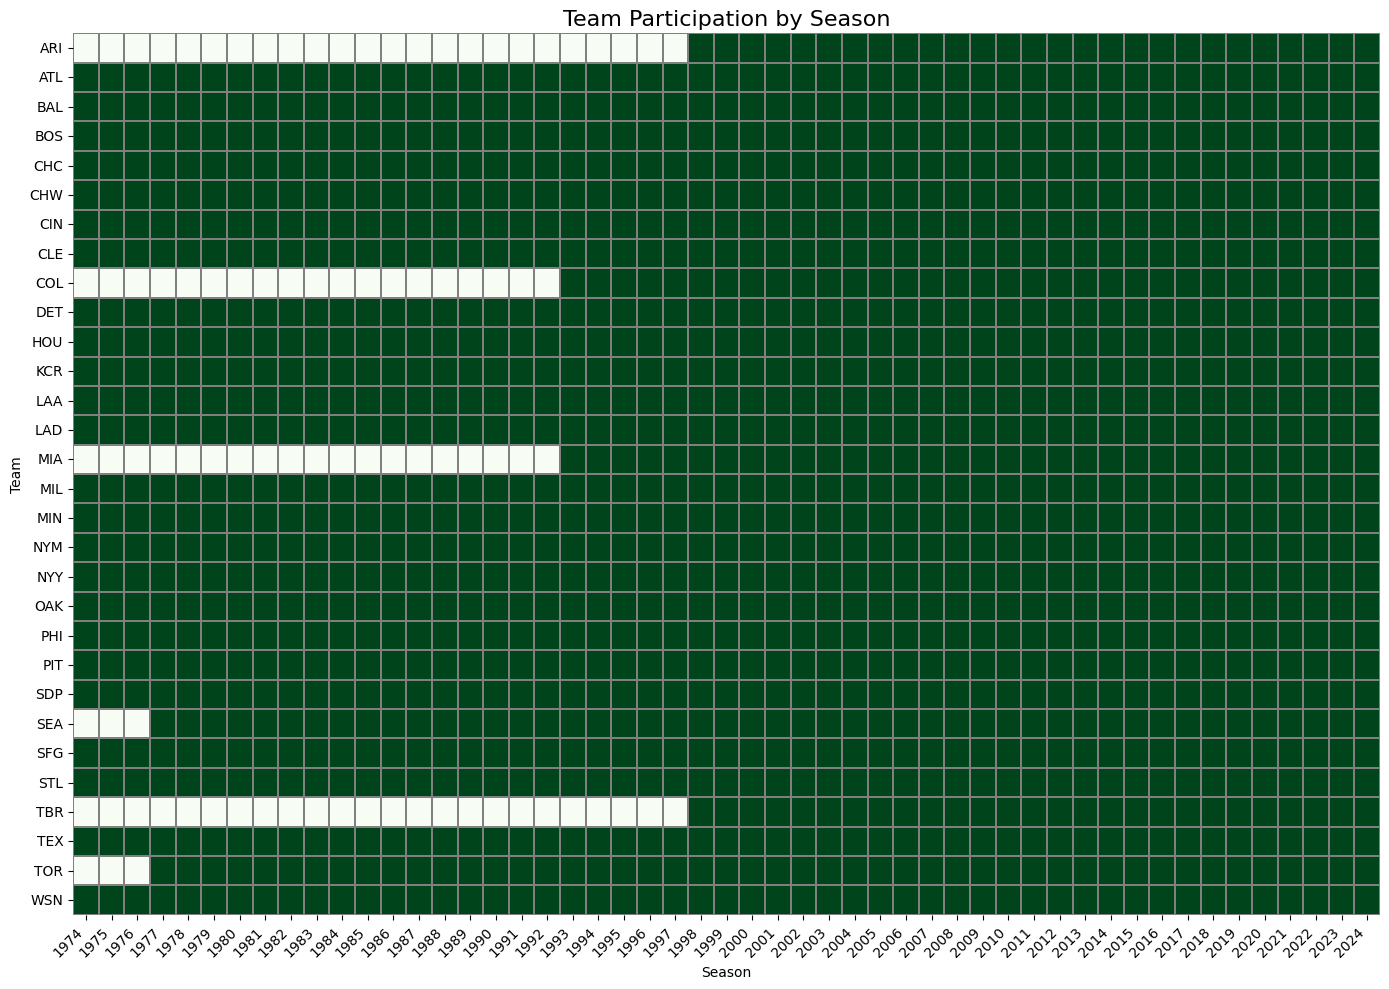

In [2]:
# Loading our data frame
df = pd.read_csv('data/BaseballData590.csv', na_values=['?'])
# Visualizing a summary of the df
df = df.rename(columns={'WL%': 'WinPct'})
df.head()


df['Team'] = df['Team'].replace({
    'MON': 'WSN',
    'ANA': 'LAA',
    'FLA': 'MIA',
    'TBD': 'TBR',
    'CAL': 'LAA'
})

team_year_matrix = (
    df[['Season', 'Team']]
    .drop_duplicates()
    .assign(value=1)
    .pivot(index='Team', columns='Season', values='value')
    .fillna(0)
)

# 2. Sort rows alphabetically, and columns chronologically
team_year_matrix = team_year_matrix.sort_index().sort_index(axis=1)

# 3. Plot the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(team_year_matrix, cmap='Greens', cbar=False, linewidths=0.2, linecolor='gray')

plt.title("Team Participation by Season", fontsize=16)
plt.xlabel("Season")
plt.ylabel("Team")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Second SARIMAX model

In [ ]:
subset_vars = ['PA', 'R', 'LOB', 'IP']

In [4]:
# Filtering just the Yankees and sorting by season
yankees_df = df[df['Team'] == 'NYY'].sort_values('Season').reset_index(drop =  True)

# Select key columns: target (WinPct) and two predictors (e.g. ERA, OPS)
cols_to_use = ['Season', 'WinPct', 'PA', 'R', 'LOB', 'IP']
yankees_df = yankees_df[cols_to_use].dropna()

# Shift predictors one year back so we only use past data to predict next season
yankees_df['PA_lag'] = yankees_df['PA'].shift(1)
yankees_df['R_lag'] = yankees_df['R'].shift(1)
yankees_df['LOB_lag'] = yankees_df['LOB'].shift(1)
yankees_df['IP_lag'] = yankees_df['IP'].shift(1)


# Drop the first row (which now has NaNs in lagged predictors)
yankees_df = yankees_df.dropna().reset_index(drop=True)

# Preview the cleaned data
print(yankees_df.head())

   Season  WinPct    PA    R   LOB      IP  PA_lag  R_lag  LOB_lag  IP_lag
0    1975   0.519  6039  681  1091  1424.0  6182.0  671.0   1173.0  1455.2
1    1976   0.610  6158  730  1107  1455.1  6039.0  681.0   1091.0  1424.0
2    1977   0.617  6261  831  1142  1449.1  6158.0  730.0   1107.0  1455.1
3    1978   0.613  6220  735  1153  1460.2  6261.0  831.0   1142.0  1449.1
4    1979   0.556  6061  734  1063  1432.0  6220.0  735.0   1153.0  1460.2


## Checking for Stationarity

In [5]:
# Run the ADF test on the WinPct series
result = adfuller(yankees_df['WinPct'])

# Print the test statistic and p-value
print("ADF Test Statistic:", result[0])
if result[1] < 0.05:
    print("our p-value:", result[1], "is less than 0.05")
else:
    print("our p-value:", result[1], "is greater than 0.05")

ADF Test Statistic: -3.9706352720852878
our p-value: 0.0015723244592452962 is less than 0.05


In [6]:
order = (1, 0, 1)  # AR(1), no differencing, MA(1)
# Define the target and exogenous variables
y = yankees_df['WinPct']
X = yankees_df[['PA_lag', 'R_lag', 'LOB_lag', 'IP_lag']]

# Define and fit the SARIMAX model
model = SARIMAX(endog=y, exog=X, order=(1, 0, 1))
results = model.fit()

# Print the summary
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                 WinPct   No. Observations:                   50
Model:               SARIMAX(1, 0, 1)   Log Likelihood                  59.536
Date:                Fri, 18 Apr 2025   AIC                           -105.071
Time:                        14:56:27   BIC                            -91.687
Sample:                             0   HQIC                           -99.974
                                 - 50                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
PA_lag        -0.0008      0.002     -0.476      0.634      -0.004       0.003
R_lag          0.0008      0.001      0.581      0.561      -0.002       0.004
LOB_lag        0.0010      0.002      0.541      0.5

c:\Users\mateo\Github\Econ590\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [7]:
# Version 2: 80 - 20

results = []

for team in df['Team'].unique():
    team_df = df[df['Team'] == team].sort_values('Season').reset_index(drop=True)

    # Skip if missing data
    if team_df[['WinPct', 'PA', 'R', 'LOB', 'IP']].isnull().any().any():
        continue

    # Add lagged predictors
    team_df['PA_lag'] = team_df['PA'].shift(1)
    team_df['R_lag'] = team_df['R'].shift(1)
    team_df['LOB_lag'] = team_df['LOB'].shift(1)
    team_df['IP_lag'] = team_df['IP'].shift(1)
    team_df = team_df.dropna().reset_index(drop=True)

    total_rows = len(team_df)
    if total_rows < 15:
        continue  # still skip very short histories

    # Split by index (chronologically): 80% train, 20% test
    split_idx = int(total_rows * 0.8)
    train = team_df.iloc[:split_idx]
    test = team_df.iloc[split_idx:]

    y_train = train['WinPct']
    X_train = train[['PA_lag' , 'R_lag', 'LOB_lag', 'IP_lag']]
    y_test = test['WinPct']
    X_test = test[['PA_lag' , 'R_lag', 'LOB_lag', 'IP_lag']]

    try:
        model = SARIMAX(endog=y_train, exog=X_train, order=(1, 0, 1),
                        enforce_stationarity=False, enforce_invertibility=False)
        model_fit = model.fit(disp=False)
        pred = model_fit.predict(start=test.index[0], end=test.index[-1], exog=X_test)

        rmse = np.sqrt(mean_squared_error(y_test, pred))
        mae = mean_absolute_error(y_test, pred)

        results.append({
            'Team': team,
            'Test RMSE': round(rmse, 4),
            'Test MAE': round(mae, 4),
            'Train Size': len(train),
            'Test Size': len(test)
        })

    except Exception as e:
        print(f"Model failed for {team}: {e}")

# STEP 4: Create a results dataframe
results_df2 = pd.DataFrame(results).sort_values('Test RMSE')

results_df2.reset_index(drop=True, inplace=True)
results_df2

c:\Users\mateo\Github\Econ590\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\mateo\Github\Econ590\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\mateo\Github\Econ590\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\mateo\Github\Econ590\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\mateo\Github\Econ590\.venv\Lib\site-packages\st

,Team,Test RMSE,Test MAE,Train Size,Test Size
0,ARI,8.970000e-02,7.680000e-02,20,6
1,PIT,9.140000e-02,6.650000e-02,40,10
2,TEX,9.260000e-02,7.100000e-02,40,10
3,WSN,9.930000e-02,7.860000e-02,40,10
4,LAA,1.080000e-01,7.570000e-02,40,10
5,PHI,1.129000e-01,6.790000e-02,40,10
6,CHC,1.148000e-01,8.830000e-02,40,10
7,SDP,1.150000e-01,8.150000e-02,40,10
8,MIA,1.151000e-01,9.500000e-02,24,7
9,KCR,1.206000e-01,9.150000e-02,40,10


Although the best subset linear regression model identified PA, R, LOB, and IP as strong predictors of team win percentage in a static, cross-sectional setting, these variables performed significantly worse in the time series SARIMAX framework compared to OPS and ERA. This discrepancy likely stems from the fact that best subset selection optimizes for explanatory power within the training sample without accounting for temporal stability. In contrast, OPS and ERA are rate-based performance metrics that summarize key offensive and pitching performance in a more stable and temporally consistent way, making them better suited for year-over-year forecasting. As a result, while best subset predictors may fit past data well, they introduce more noise when lagged and used for out-of-sample time series prediction